there is another dataset
I think the dataset you worked on is all about the ship
not necessary. I think it is easy to find the coordinates of gas station. So I think this dataset has ship location. We can assume a ship around the gas station is to try to fill the gas. Then track the ship. And based on the ship size, we can calculate how much the oil left in its tank
And of course, we might need some expert knowledge of the MPG of a ship of certain size
the dataset I gave you is one day's data. We might need to rollup multiple days

Updates
Client is focused
* on fueling of fishing ships only
  * filter out other types

Calculating gas left in tank
* total volume of tank = t
* distance time fuel consumption

When ship enters a port
* Ship will fill gas tank?
  * not necessarily true
* if ship goes to a port went to second port in rapid succession.

Distance
Ship activity during the day
* time
* groundSpeed
* lat long?
* fuel consumption?

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates

In [2]:
pathData = '''D:\\data\\ships\\'''
shipFileName = '''st.txt'''
sailingFileName ='''dy.txt'''

schemaDynamic = ['timestampUNIX',
    'MMSI', # (Maritime Mobile Service Identity)
    'navCondition',
    'steeringRate',
    'speedOverGround',
    'deviceAccuracy',
    'longitude',
    'latitude',
    'gpsCOG', # Course over ground
    'heading',
    'utcVerificationSeconds',
    'packetID',
    'dataSourceID']
schemaStatic = ['timestampUNIX',
    'MMSI', # (Maritime Mobile Service Identity)
    'IMO', # (International Maritime Organization)
    'callsign',
    'vessel',
    'shipType',
    'captain',
    'breadth',
    'pointingDeviceType',
    'eta',
    'currentDraft',
    'destination',
    'packetID',
    'dataSourceID']

In [3]:
#shipData = pd.read_csv(pathData, header=None, engine='c', skiprows=[83988, 137058, 288322])
shipData = pd.read_csv(pathData+shipFileName, header=None, engine='c', quoting=3, error_bad_lines=False)
sailingData = pd.read_csv(pathData+sailingFileName, header=None, engine='c', quoting=3, error_bad_lines=False)

In [4]:
shipData.columns = schemaStatic
sailingData.columns = schemaDynamic

In [5]:
shipData.head()

,timestampUNIX,MMSI,IMO,callsign,vessel,shipType,captain,breadth,pointingDeviceType,eta,currentDraft,destination,packetID,dataSourceID
0,1409501013,219905000,0,XP5174,L68 JANGA BORK,30,18,6,1,1596,30,CH 16 FOR DEST,5,103
1,1409501013,219946000,0,OZYD,HELLE JES,30,21,6,1,1596,0,HUIDB SANDE,5,103
2,1409501013,261182647,0,SR2647,KRYSTYNA,99,62,8,15,568448,2,KALININGRAD *:,5,103
3,1409501013,265623790,0,NaN,EMM XXIII,0,0,0,0,0,0,NaN,24,103
4,1409501013,305477000,9160334,V2EM4,VECHTBORG,70,133,16,1,582656,48,BREMEN BY KIEL CANAL,5,103


In [6]:
sailingData.head()

,timestampUNIX,MMSI,navCondition,steeringRate,speedOverGround,deviceAccuracy,longitude,latitude,gpsCOG,heading,utcVerificationSeconds,packetID,dataSourceID
0,1409501013,205218000,5,0,0,1,-0.071837,53.579707,1482,208,45,3,103
1,1409501013,211596150,0,0,0,1,12.098808,54.181470,3600,511,47,18,103
2,1409501013,231742000,0,0,72,1,-6.759133,62.081663,1401,511,32,18,103
3,1409501013,232000760,0,129,129,0,-2.710517,59.292250,2335,231,47,1,103
4,1409501013,235031438,0,0,0,0,11.849462,57.670968,2716,511,47,18,103


# Join ship data to sailing Data by MMSI

Note there was a memory error when joining entire day of sailingData

Therefore:
* These data sets need to be in a DB
* For now test algorithms on a single MMSI

In [7]:
# Use only a few rows due to memory issues
sampleSize = 1000

# Sample of 5 MMSI's and a single MMSI
exampleMMSIList = sailingData.MMSI.unique()[0:sampleSize]
exampleMMSI = exampleMMSIList[0]

In [8]:
pd.DataFrame.drop_duplicates

<function pandas.core.frame.DataFrame.drop_duplicates>

In [9]:
shipData.loc[shipData.MMSI == exampleMMSI, ['MMSI', 'IMO', 'callsign', 'vessel', 'shipType', 
                                          'captain', 'breadth', 
                                          'eta', 'currentDraft', 'destination']].drop_duplicates()

,MMSI,IMO,callsign,vessel,shipType,captain,breadth,eta,currentDraft,destination
117369,205218000,8222563,ORGQ,BNS BELGICA,1,51,10,1596,0,NaN
1134972,205218000,8222563,ORGQ,BNS BELGICA,1,51,10,0,0,NaN


In [10]:
exampleFilter = sailingData.MMSI.apply(lambda x: x in exampleMMSIList)
sailingShipData = pd.merge(left=sailingData.loc[exampleFilter, :], 
                           right=shipData.loc[:, ['timestampUNIX','MMSI', 'IMO', 'callsign', 'vessel', 'shipType', 
                                          'captain', 'breadth', 
                                          'eta', 'currentDraft', 'destination']].drop_duplicates(), 
                           how='left', 
                           on=['timestampUNIX', 'MMSI'])

In [11]:
sailingShipData.columns

Index(['timestampUNIX', 'MMSI', 'navCondition', 'steeringRate',
       'speedOverGround', 'deviceAccuracy', 'longitude', 'latitude', 'gpsCOG',
       'heading', 'utcVerificationSeconds', 'packetID', 'dataSourceID', 'IMO',
       'callsign', 'vessel', 'shipType', 'captain', 'breadth', 'eta',
       'currentDraft', 'destination'],
      dtype='object')

In [34]:
# Add some features
sailingShipData.loc[:, 'longLat'] = pd.Series(list(zip(sailingShipData.longitude, sailingShipData.latitude)), index=sailingShipData.index)
sailingShipData.loc[:, 'datestring'] = pd.to_datetime(sailingShipData.timestampUNIX, unit='s')
print(sailingShipData.datestring.min(), sailingShipData.datestring.max())

In [72]:
sailingShipData.head()

,timestampUNIX,MMSI,navCondition,steeringRate,speedOverGround,deviceAccuracy,longitude,latitude,gpsCOG,heading,...,callsign,vessel,shipType,captain,breadth,eta,currentDraft,destination,longLat,datestring
0,1409501013,205218000,5,0,0,1,-0.071837,53.579707,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071837, 53.579707)",2014-08-31 16:03:33
1,1409501013,211596150,0,0,0,1,12.098808,54.181470,3600,511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(12.098808, 54.18147)",2014-08-31 16:03:33
2,1409501013,231742000,0,0,72,1,-6.759133,62.081663,1401,511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-6.759133, 62.081663)",2014-08-31 16:03:33
3,1409501013,232000760,0,129,129,0,-2.710517,59.292250,2335,231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-2.710517, 59.29225)",2014-08-31 16:03:33
4,1409501013,235031438,0,0,0,0,11.849462,57.670968,2716,511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(11.849462, 57.670968)",2014-08-31 16:03:33


# Sample down to a single ship

In [13]:
print('Number of rows in sailingData %i' % sailingData.shape[0])
print('Number of rows in sampled sailingData joined to shipData %i' % sailingShipData.shape[0])

Number of rows in sailingData 18484008
Number of rows in sampled sailingData joined to shipData 1225857


In [14]:
print('Number of ships in sample = %i' % len(sailingShipData.MMSI.unique()))
print('Example of distance is calculated on MMSI = %i' % exampleMMSI)

Number of ships in sample = 1000
Example of distance is calculated on MMSI = 205218000


Each ship actually has multiple entries in the static Data set too, representing the ship's changing state over the course of the journey. Joing sailing data to ship data needs to be done on both MMSI and timestamp, where MMSI 

In [15]:
print('Number of data points in unsampled sailingData for sample MMSI = %i' % sailingData[sailingData.MMSI == 205218000].shape[0])
print('Number of data points in unsampled shipData for sample MMSI = %i' % shipData[shipData.MMSI == 205218000].shape[0])
print('Number of data points in sampled sailingShipData for sample MMSI = %i' % sailingShipData[sailingShipData.MMSI == 205218000].shape[0])

Number of data points in unsampled sailingData for sample MMSI = 341
Number of data points in unsampled shipData for sample MMSI = 38
Number of data points in sampled sailingShipData for sample MMSI = 341


# Calculate distance traveled by ship

Calculating distance between two location (lat, long) tuples requires accounting for curvature in the earth's surface:
* http://www.movable-type.co.uk/scripts/latlong.html
* https://en.wikipedia.org/wiki/Spherical_law_of_cosines

#### Haversine formula
Given two points (A_Lat, A_Long), (B_Lat, B_Long) the distance:
* $C = sin(A_{Lat})sin(B_{Lat}) + cos(A_{Lat})cos(B_{Lat})cos(A_Long-B_{Long})$
* $Distance = RArccos(C)\frac{\pi}{180}$
  * Where, R is the average earth radius, which is 6371.004 km. 

I will need a new dataset that has ship to distance travelled, which should be derived from the sailing dataset.

In [16]:
# Very few of the timestamps line up between the sailing and ship data sets, but surprisingly some do
sailingShipData[(sailingShipData.MMSI == 205218000) & (sailingShipData.currentDraft.isnull() == False)]

,timestampUNIX,MMSI,navCondition,steeringRate,speedOverGround,deviceAccuracy,longitude,latitude,gpsCOG,heading,...,dataSourceID,IMO,callsign,vessel,shipType,captain,breadth,eta,currentDraft,destination
443789,1409527534,205218000,5,0,0,0,-0.071813,53.579703,1482,208,...,38,8222563.0,ORGQ,BNS BELGICA,1.0,51.0,10.0,0.0,0.0,NaN
730859,1409548254,205218000,5,0,0,1,-0.071848,53.579712,1482,208,...,101,8222563.0,ORGQ,BNS BELGICA,1.0,51.0,10.0,1596.0,0.0,NaN
1003232,1409570271,205218000,0,129,29,0,0.647547,53.444705,792,41,...,38,8222563.0,ORGQ,BNS BELGICA,1.0,51.0,10.0,0.0,0.0,NaN


2014-08-31 16:03:33 2014-09-01 16:13:16


# Calculate distance traveled by one ship from sorted data points

In [36]:
oneShip = sailingShipData.loc[(sailingShipData.MMSI == 205218000)]
oneShip.sort(columns='timestampUNIX', inplace=True)

C:\Users\Ulric\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\frame.py:3218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


In [37]:
oneShip.head()

,timestampUNIX,MMSI,navCondition,steeringRate,speedOverGround,deviceAccuracy,longitude,latitude,gpsCOG,heading,...,IMO,callsign,vessel,shipType,captain,breadth,eta,currentDraft,destination,longLat
0,1409501013,205218000,5,0,0,1,-0.071837,53.579707,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071837, 53.579707)"
3156,1409501180,205218000,5,0,0,1,-0.071832,53.579700,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071832, 53.5797)"
6990,1409501360,205218000,5,0,0,1,-0.071833,53.579705,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071833, 53.579705)"
10915,1409501541,205218000,5,0,0,1,-0.071827,53.579693,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071827, 53.579693)"
14584,1409501721,205218000,5,0,0,1,-0.071827,53.579700,1482,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-0.071827, 53.5797)"


In [15]:
oneShip.shape

(341, 22)

In [38]:
from math import radians, cos, sin, asin, sqrt

def haversineDistanceKm(longLatTuple):

#     if len(longLatList.shape) < 2:
#         return np.nan
    
#     if isinstance(longLatList, np.ndarray):
#         return np.nan #longLatList
    
    a = longLatTuple[0]
    b = longLatTuple[1]
    
#     if a == -7.18370000e-02:
#         return np.nan
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [a[0], a[1], b[0], b[1]])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles

    return c * r
    
testGeos = [(-7.18370000e-02,   5.35797070e+01),
       ( -7.18320000e-02,   5.35797000e+01)]

haversineDistanceKm(testGeos)

0.0008454625664661584

In [39]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [40]:
distances = [0] + [haversineDistanceKm(longLatWindow )for longLatWindow in list(window(oneShip.longLat))]

In [41]:
oneShip.loc[:, 'incrementalDistanceKm'] = pd.Series(distances, index=oneShip.index)

C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
oneShip.loc[:, 'cumulativeDistanceKm'] = oneShip.incrementalDistanceKm.cumsum()

C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Haversine Distances: incremental and cumulative

In [23]:
oneShip.loc[:, ['datestring', 'longLat', 'incrementalDistanceKm', 'cumulativeDistanceKm']].head()

,datestring,longLat,incrementalDistanceKm,cumulativeDistanceKm
0,NaN,"(-0.071837, 53.579707)",0.000000,0.000000
3156,NaN,"(-0.071832, 53.5797)",0.000845,0.000845
6990,NaN,"(-0.071833, 53.579705)",0.000560,0.001405
10915,NaN,"(-0.071827, 53.579693)",0.001392,0.002797
14584,NaN,"(-0.071827, 53.5797)",0.000778,0.003576


In [24]:
oneShip.loc[:, ['datestring', 'longLat', 'incrementalDistanceKm', 'cumulativeDistanceKm']].tail()

,datestring,longLat,incrementalDistanceKm,cumulativeDistanceKm
1000571,NaN,"(0.671697, 53.470618)",1.128934,54.985451
1003232,NaN,"(0.647547, 53.444705)",3.295290,58.280741
1012798,NaN,"(0.684068, 53.485382)",5.128616,63.409357
1025280,NaN,"(0.707017, 53.516108)",3.738563,67.147920
1048320,NaN,"(0.747457, 53.556685)",5.244023,72.391942


# Calculate Haversine Distances for all ships in dataframe

In [98]:
def dataFrameHaversineCalculation(df):
    # make sure the dataframe is sorted or this won't work
    df.sort_values(by='timestampUNIX', axis=0, ascending=True, inplace=True)
    
    results = pd.DataFrame(columns= ['timestampUNIX', 'MMSI', 'incrementalDistanceKm', 'cumulativeDistanceKm', 'totalDistanceKm'])
    
    for ship in list(df.MMSI.unique()):
        currentData = df.loc[df.MMSI == ship, ['timestampUNIX', 'MMSI', 'longLat']]
        distances = [0] + [haversineDistanceKm(longLatWindow )for longLatWindow in list(window(currentData.longLat))]
        currentData.loc[:, 'incrementalDistanceKm'] = pd.Series(distances, index=currentData.index)
        currentData.loc[:, 'cumulativeDistanceKm'] = currentData.incrementalDistanceKm.cumsum()
        currentData.loc[:, 'totalDistanceKm'] = currentData.loc[:, 'cumulativeDistanceKm'].max()
        results = pd.concat([results, currentData.loc[:, ['timestampUNIX', 'MMSI', 'incrementalDistanceKm', 'cumulativeDistanceKm', 'totalDistanceKm']]])
        
    return results

In [99]:
dfDistances = dataFrameHaversineCalculation(sailingShipData)
dfDistances.head()

,timestampUNIX,MMSI,incrementalDistanceKm,cumulativeDistanceKm,totalDistanceKm
0,1.409501e+09,205218000.0,0.000000,0.000000,72.391245
3156,1.409501e+09,205218000.0,0.000845,0.000845,72.391245
6990,1.409501e+09,205218000.0,0.000560,0.001405,72.391245
10915,1.409502e+09,205218000.0,0.001392,0.002797,72.391245
14584,1.409502e+09,205218000.0,0.000778,0.003576,72.391245


In [100]:
sailingShipDistanceData = pd.merge(left = sailingShipData, right = dfDistances, how='left', on=['timestampUNIX', 'MMSI'])

In [101]:
sailingShipDistanceData.tail()

,timestampUNIX,MMSI,navCondition,steeringRate,speedOverGround,deviceAccuracy,longitude,latitude,gpsCOG,heading,...,captain,breadth,eta,currentDraft,destination,longLat,datestring,incrementalDistanceKm,cumulativeDistanceKm,totalDistanceKm
1339036,1409587975,413375380,3,0,16,1,120.956690,31.782697,2651,279,...,NaN,NaN,NaN,NaN,NaN,"(120.95669, 31.782697)",2014-09-01 16:12:55,0.017718,1.141393e+02,1.141483e+02
1339037,1409587978,413000000,0,0,0,0,120.758262,32.020350,0,0,...,NaN,NaN,NaN,NaN,NaN,"(120.758262, 32.02035)",2014-09-01 16:12:58,0.000292,3.836817e+06,3.836817e+06
1339038,1409587985,413375380,3,0,17,1,120.956595,31.782688,2653,279,...,NaN,NaN,NaN,NaN,NaN,"(120.956595, 31.782688)",2014-09-01 16:13:05,0.009035,1.141483e+02,1.141483e+02
1339039,1409587986,412070380,3,0,0,0,120.450667,31.991500,2670,205,...,NaN,NaN,NaN,NaN,NaN,"(120.450667, 31.9915)",2014-09-01 16:13:06,0.000000,3.806403e+01,3.806403e+01
1339040,1409587996,413991126,0,0,52,0,120.907045,31.848975,3432,511,...,NaN,NaN,NaN,NaN,NaN,"(120.907045, 31.848975)",2014-09-01 16:13:16,0.073071,1.080944e+02,1.080944e+02


In [83]:
sailingShipDistanceData.loc[temp.MMSI == 205218000, ['datestring', 'longLat', 'incrementalDistanceKm', 'cumulativeDistanceKm']].head()

,datestring,longLat,incrementalDistanceKm,cumulativeDistanceKm
0,2014-08-31 16:03:33,"(-0.071837, 53.579707)",0.000000,0.000000
3268,2014-08-31 16:06:20,"(-0.071832, 53.5797)",0.000845,0.000845
7344,2014-08-31 16:09:20,"(-0.071833, 53.579705)",0.000560,0.001405
11549,2014-08-31 16:12:21,"(-0.071827, 53.579693)",0.001392,0.002797
15462,2014-08-31 16:15:21,"(-0.071827, 53.5797)",0.000778,0.003576


# Plot activity in a day

When activity is plotted on a sample of 1000 ships, the activity appears random.

However, this may be because the ships are active in many time zones across the world

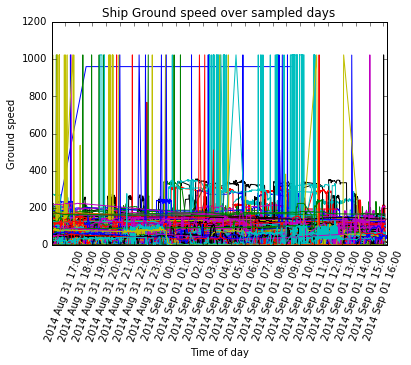

In [25]:
dateFormatter = matplotlib.dates.DateFormatter('%Y %b %d %H:%M')
dateLocator = matplotlib.dates.HourLocator(byhour=None, interval=1, tz=None)

# dateLocator = matplotlib.dates.AutoDateLocator()
# dateFormatter = matplotlib.dates.AutoDateFormatter(dateLocator)
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(dateFormatter)
ax.xaxis.set_major_locator(dateLocator)
#ax.scatter(pd.to_datetime(oneShip.timestampUNIX, unit='s'), oneShip.speedOverGround)
#ax.scatter(oneShip.timestampUNIX, oneShip.speedOverGround)

for ship in sailingShipData.MMSI.unique():
    plotData = sailingShipData.loc[sailingShipData.MMSI == ship]
    ax.plot_date(pd.to_datetime(plotData.timestampUNIX, unit='s'), plotData.speedOverGround, fmt='-', label=ship)

# common aesthetics

ax.set_xlabel('Time of day')
ax.set_ylabel('Ground speed')

# ax.set_ylim([40, 110])

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(70)

ax.set_title('Ship Ground speed over sampled days')

### Small sample of ships

For these 6 ships, that are likely from the same timezone, they only seem to be travelling from 0700h to 2000h.

Therefore, there may exists a pattern of anchor vs. travel that would become obvious if we localized the timestamps of the data to the local time zones

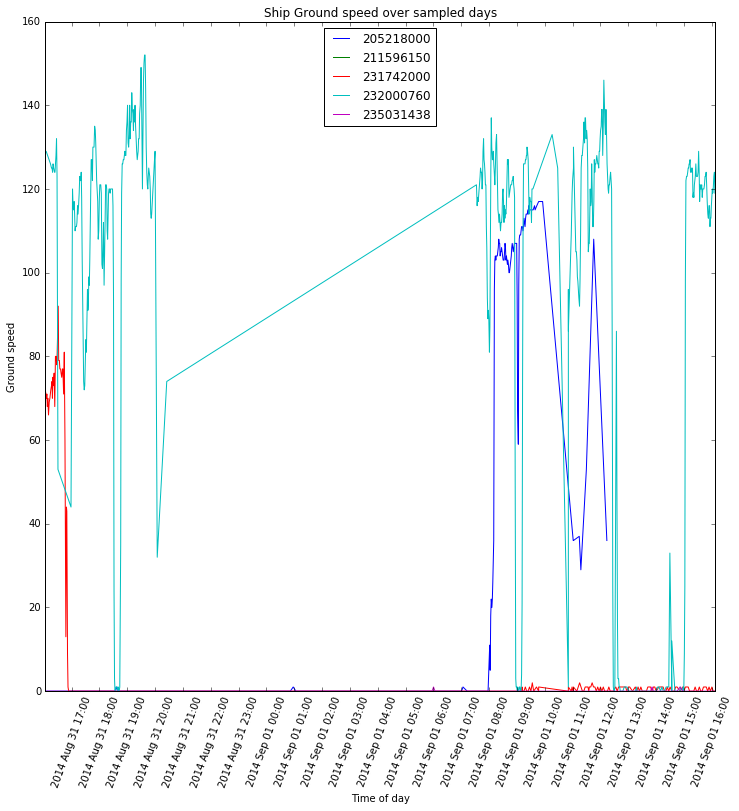

In [26]:
shipList = sailingShipData.MMSI.unique()[:5]

fig, ax = plt.subplots(figsize=(12, 12))
ax.xaxis.set_major_formatter(dateFormatter)
ax.xaxis.set_major_locator(dateLocator)

for ship in shipList:
    plotData = sailingShipData.loc[sailingShipData.MMSI == ship]
    ax.plot_date(pd.to_datetime(plotData.timestampUNIX, unit='s'), plotData.speedOverGround, fmt='-', label=ship)

# common aesthetics

ax.set_xlabel('Time of day')
ax.set_ylabel('Ground speed')

# ax.set_ylim([40, 110])

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(70)

ax.set_title('Ship Ground speed over sampled days')
ax.legend(loc='best')

# Plot location of points

This plot confirms the ships' location data are from all over the world. The long lines of travel suggest the presence of erroneous data representing impossible locations and changes of location.

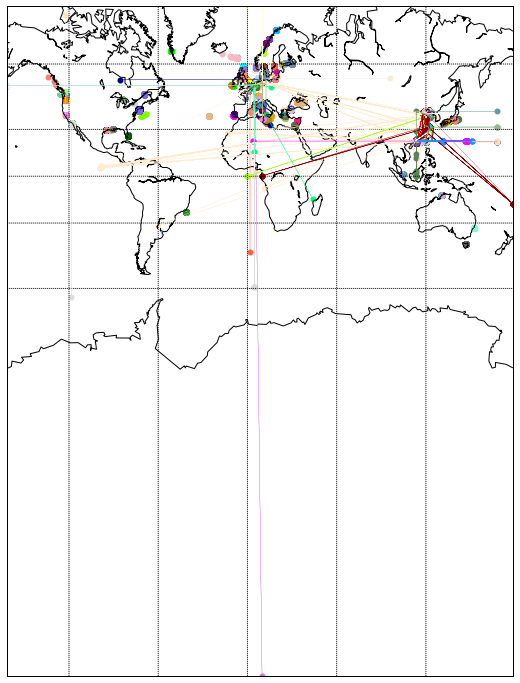

In [27]:
plt.figure(figsize=(12, 12))

# setup Lambert Conformal basemap.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)

minLat = sailingShipData.latitude.min()
maxLat = sailingShipData.latitude.max()
minLong = sailingShipData.longitude.min()
maxLong = sailingShipData.longitude.max()

m = Basemap(projection='merc',llcrnrlat=minLat,urcrnrlat=maxLat,\
            llcrnrlon=minLong,urcrnrlon=maxLong,lat_ts=20,resolution='c')

# draw coastlines.
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))

# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
#m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
#m.fillcontinents(color='white',lake_color='aqua')

colorList = list(matplotlib.colors.cnames.keys())

for i, ship in enumerate(sailingShipData.MMSI.unique()):
    plotData = sailingShipData.loc[sailingShipData.MMSI == ship, ['latitude', 'longitude']].dropna()
    x, y = m(plotData.longitude.values, plotData.latitude.values)
    m.scatter(x,y,linewidth=1.5, color=colorList[np.mod(i, len(colorList))])
    m.plot(x,y,linewidth=.25, color=colorList[np.mod(i, len(colorList))])

plt.show()

# Plot a small number of ships

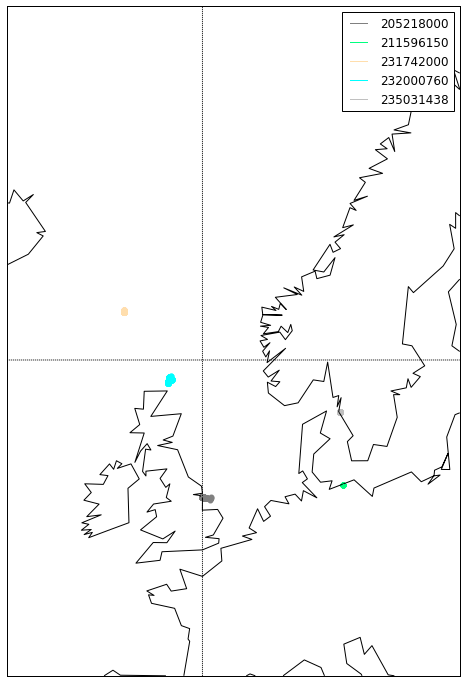

In [28]:
plt.figure(figsize=(12, 12))

# setup Lambert Conformal basemap.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)

shipList = sailingShipData.MMSI.unique()[:5]
shipFilter = sailingShipData.MMSI.isin(shipList)
geoBuffer = 10.0

# Latitude is bounded between -90 and 90.  Longitude is not in this API
minLat = np.max([-89.0, sailingShipData.loc[shipFilter, 'latitude'].min() - geoBuffer])
maxLat = np.min([89.0, sailingShipData.loc[shipFilter, 'latitude'].max() + geoBuffer])
minLong = sailingShipData.loc[shipFilter, 'longitude'].min() - geoBuffer
maxLong = sailingShipData.loc[shipFilter, 'longitude'].max() + geoBuffer

m = Basemap(projection='merc',llcrnrlat=minLat,urcrnrlat=maxLat,\
            llcrnrlon=minLong,urcrnrlon=maxLong,lat_ts=20,resolution='c')

# draw coastlines.
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))

# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
#m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
#m.fillcontinents(color='white',lake_color='aqua')

colorList = list(matplotlib.colors.cnames.keys())

for i, ship in enumerate(shipList):
    plotData = sailingShipData.loc[sailingShipData.MMSI == ship, ['latitude', 'longitude']].dropna()
    x, y = m(plotData.longitude.values, plotData.latitude.values)
    m.scatter(x,y,linewidth=1.5, color=colorList[np.mod(i, len(colorList))])
    m.plot(x,y,linewidth=1.0, color=colorList[np.mod(i, len(colorList))], label = ship)

plt.legend(loc='best')    
plt.show()